# Residual Extraction Demonstration With Synthetic Signal

## Loading Libraries

In [64]:
from numpy import arange, sin, pi, median
from numpy.random import randn
from datetime import datetime, timedelta
from pandas import DataFrame
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.robust import mad

## Creating Synthetic with Injected Anomalies
The signal below is built with a pre-defined seasonality, noise and some anomalies.
The first 2 anomalies are very high and represent global anomalies and the other 2 anomalies are local anomalies can only be perceived in terms of the seasonality.

### Creating the Signal

In [22]:
item_range = arange(0, 24*5)
residual = randn(len(item_range))
seasonality = sin( item_range * 2 * pi / 24 )*20
signal = seasonality + residual*2

# Anomalies
signal[30] = 42
signal[35] = 43
signal[65] = 17
signal[70] = 15

time_axis = [ datetime(2018,1,5) + timedelta(hours=float(item)) for item in item_range ]

data_matrix = [ time_axis, signal ]

signal_df = DataFrame(signal)
signal_df.index = time_axis
signal_df.head(n=5)

,0
2018-01-05 00:00:00,-0.104377
2018-01-05 01:00:00,7.628356
2018-01-05 02:00:00,10.700359
2018-01-05 03:00:00,11.573656
2018-01-05 04:00:00,14.735433


The signal is designed with the following characteristics:
* regularly collected - 1 data point per hour
* daily seasonal pattern (every 24 data points)
* 2 global anomalies - perceived outside of signal normal value range 
* 2 local anomalies - perceived only when seasonality is taken in consideration

### Signal Visualization

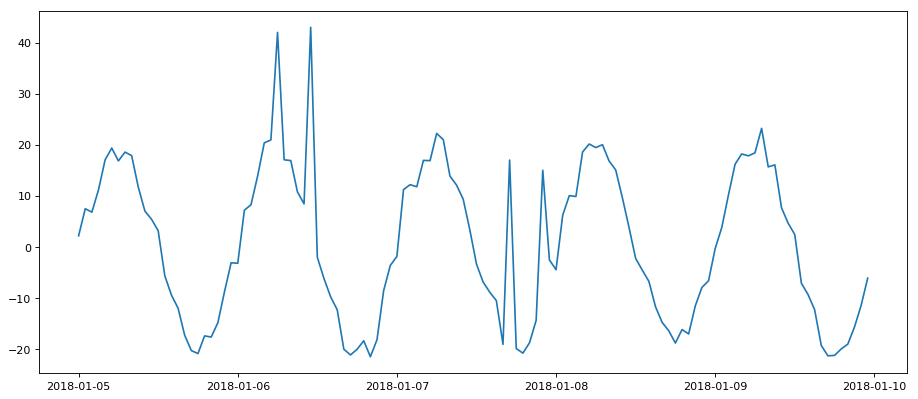

In [18]:
pyplot.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(signal_df)
pyplot.show()

## Seasonal Trend Decomposition
Signal is decomposed given its seasonal frequency of 24 data points with *additive* model since the magnitude doesn't increase with trend. In fact, this signal has no visible trend.

The original signal is decomposed in 3 components: trend, seasonal and residual.
* trend - represents the signal behavior to go up or down 
* seasonal - the part of the signal that repeats given a frequency 
* residual - everything else in the signal that does not match the trend or seasonal

<Figure size 1120x480 with 0 Axes>

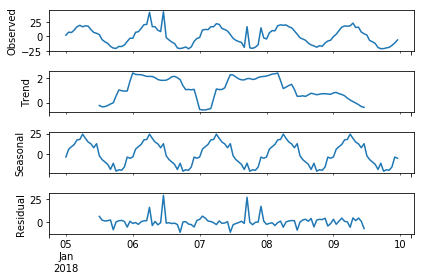

In [21]:
synthetic_ts = seasonal_decompose(signal_df, freq=24, model='additive')
pyplot.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
synthetic_ts.plot()
pyplot.show()

Note above the seasonal decomposition above is done with moving averages therefore a window of 24 data points is used therefore there are no data points in the 24 data points in the begining and at the end of the trend and the residual components.

### Extract Residual Component
Residual component can be extracted and when it is side-by-side plotted with the observed signal, we can visually see how the anomalies are reflected in the residual.

**PS:** Note that the NAN elements are dropped from residual component. These elements appear as a result of the windowing process to calculate the trend. 

In [67]:
signal_observed = synthetic_ts.observed
signal_residual = synthetic_ts.resid.dropna()

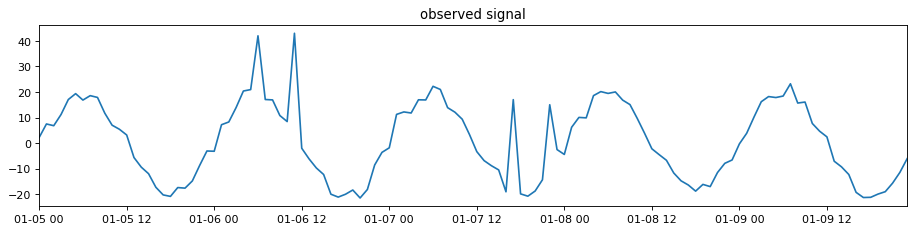

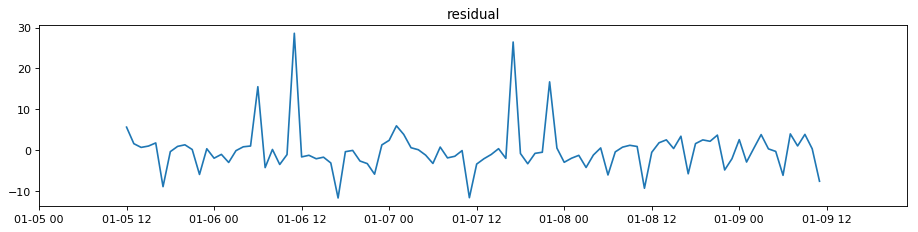

In [68]:
min_x = min(time_axis)
max_x = max(time_axis)
x_range = (min_x, max_x)
pyplot.figure(num=None, figsize=(14, 3), dpi=80, facecolor='w', edgecolor='k')
pyplot.title("observed signal")
pyplot.xlim(x_range)
pyplot.plot(signal_observed)
pyplot.show()
pyplot.figure(num=None, figsize=(14, 3), dpi=80, facecolor='w', edgecolor='k')
pyplot.title("residual")
pyplot.xlim(x_range)
pyplot.plot(signal_residual)
pyplot.show()

## Anomaly Detection over Residual Component

### Calculate Median and MAD (median absolute deviation)
Since the residual does not contain trend or seasonality, an anomaly detection technique can be easily applied.
In that particular example, a number of median absolute deviations (MAD) from the median is used due to simplicity to be explained and visualized here.

**PS:** For more robust systems, using *tuckey's fences* would be a better choice since it does not need to define any **magic numbers** as limits like X * MAD as described here.

median= -0.15817984959763898
upperlimit= [-13.29195693]
lower_limit= [12.97559723]


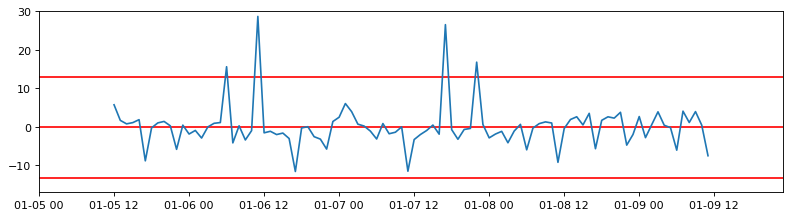

In [76]:
factor = 5
median_limit = median(signal_residual)
print('median=', median_limit)
upper_limit = median_limit - factor*mad(signal_residual)
print('upperlimit=',upper_limit)
lower_limit = median_limit + factor*mad(signal_residual)
print('lower_limit=',lower_limit)


pyplot.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')
pyplot.xlim(x_range)
pyplot.ylim((-17, 30))
pyplot.plot(signal_residual)
pyplot.hlines([upper_limit, median_limit, lower_limit], xmax=max_x, xmin=min_x, colors='r', )
pyplot.show()

### Identify Outliers from Residual

In [72]:
def is_outlier(arr, anom_factor):
    upper_limit = median(arr) + mad(arr)*anom_factor
    lower_limit = median(arr) - mad(arr)*anom_factor
    return (arr >=  upper_limit) | (arr <= lower_limit)

In [77]:
anom_residual = signal_residual[is_outlier(signal_residual, anom_factor=5).values]
anom_residual

,0
2018-01-06 06:00:00,15.553071
2018-01-06 11:00:00,28.604093
2018-01-07 17:00:00,26.465310
2018-01-07 22:00:00,16.738286


### Map Outliers to Observed Signal

In [79]:
anoms = signal_observed.filter(anom_residual.index, axis=0)
anoms

,0
2018-01-06 06:00:00,42.0
2018-01-06 11:00:00,43.0
2018-01-07 17:00:00,17.0
2018-01-07 22:00:00,15.0


## Show Final Results
Plot identified anomalies in observed signal to check final result. Can the expected anomalies be visualized ?

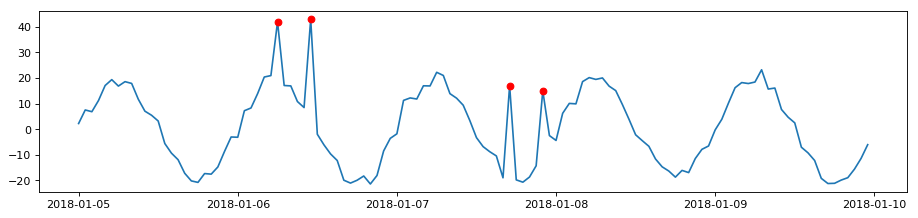

In [80]:
pyplot.figure(num=None, figsize=(14, 3), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(signal_observed)
pyplot.plot(anoms, 'ro')
pyplot.show()